# Projeto de previsão de Querys de SQL Injection

# Importações

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from keras.layers import Dense, InputLayer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento dos dados

## Importação do Dataframe

faça o download pelo link: https://www.kaggle.com/datasets/hrishi1563/sql-injection-dataset-with-sqlfeaturesvalue/data

In [2]:
df = pd.read_csv("SQL_Injection.csv", dtype={"Query": str})

## Descrição

In [3]:
df.describe()

,Label,Sentence Length,AND Count,OR Count,UNION Count,Single Quote Count,Double Quote Count,Constant Value Count,Parentheses Count,Special Characters Total
count,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000
mean,0.368123,68.594845,0.239626,0.127430,0.097222,0.833468,0.256703,2.213914,3.127494,1.447233
std,0.482303,81.068616,0.520416,0.348911,0.330919,1.663833,0.863389,3.529712,6.687481,3.909025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,80.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000
max,1.000000,5370.000000,6.000000,4.000000,3.000000,13.000000,20.000000,32.000000,44.000000,320.000000


## Correlação das colunas numéricas com o Label

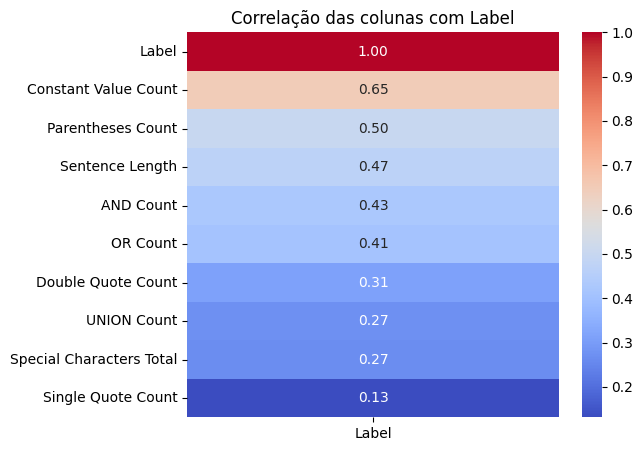

In [4]:
df_corr = df.drop(columns=["Query"]).corr()

label_corr = df_corr[["Label"]].sort_values(by="Label", ascending=False)

plt.figure(figsize=(6, len(label_corr)*0.5))
sns.heatmap(label_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlação das colunas com Label")
plt.show()

In [5]:
y = df["Label"].values

## Vectorização de texto

Abvaixo o código está convertendo texto em vetores TF-IDF, mantendo atributos tabulares, e depois unificando ambos em uma matriz única de features para treinamento/teste de um modelo.

E depois unindo aos dados tabulares do dataset

In [6]:
vectorizer = TfidfVectorizer(max_features=300)
x_query = vectorizer.fit_transform(df["Query"]).toarray()

x_tabular = df.drop(columns=["Label", "Query"]).values

#x = np.hstack([x_query, x_tabular])
x = np.hstack([x_tabular])

### Segmentação de treino e teste

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

## Modelagem

In [8]:
mlp = Sequential()
mlp.add(InputLayer(shape=(x_train.shape[1],)))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

In [9]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape     ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ dense (Dense)           │ (None, 2)        │        20 │
├─────────────────────────┼──────────────────┼───────────┤
│ dense_1 (Dense)         │ (None, 2)        │         6 │
├─────────────────────────┼──────────────────┼───────────┤
│ dense_2 (Dense)         │ (None, 1)        │         3 │
└─────────────────────────┴──────────────────┴───────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
layer_outputs = [layer.output for layer in mlp.layers]
activation_model = Model(inputs=mlp.inputs, outputs=layer_outputs)

sample_input = x_train[:1]
activations = activation_model.predict(sample_input)

for i, act in enumerate(activations):
    print(f"Camada {i} ({mlp.layers[i].name}): shape {act.shape}")
    print(act)
    print('\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Camada 0 (dense): shape (1, 2)
[[ 0.       16.011845]]


Camada 1 (dense_1): shape (1, 2)
[[0. 0.]]


Camada 2 (dense_2): shape (1, 1)
[[0.36768025]]




In [12]:
mlp.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [13]:
mlp.fit(x_train, y_train, epochs=5, verbose=0)

In [14]:
_, acuracia = mlp.evaluate(x_test, y_test)
print("Acurácia: %.2f" %(acuracia*100))

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6325 - loss: 0.6576
Acurácia: 62.85


In [15]:
previsoes = mlp.predict(x_test, verbose=1)
rounded_previsoes = [round(x[0]) for x in previsoes]

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

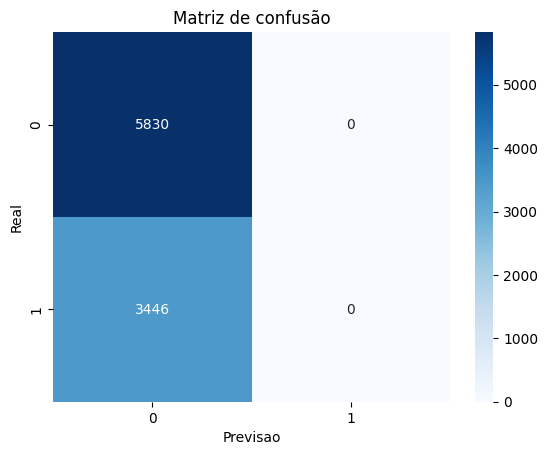

In [17]:
conf_mat = confusion_matrix(y_test, rounded_previsoes)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Previsao')
plt.ylabel('Real')
plt.title('Matriz de confusão')
plt.show()